## Strange Network Development

In [1]:
import comet_ml
from comet_ml import Experiment

import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [17]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [25]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

Set some hyperparameters for the model and data creation.

In [64]:
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 30
batch_size = 25
clean_pixels_count = 100000
max_count_per_class = 1500
steps_division_factor = 10

### The next cell is for making pixels and prepping them for training (balancing)

This takes a long time and is unnecessary if you have already saved them to text files, if so, load them below.

In [65]:
train_px, val_px, test_px, class_count_dict = rnn_pixels.balanced_pix_locations(landsat_datasets, lc_labels, 
        canopy_labels, tile_size, tile_list, clean_pixels_count, class_count, max_count_per_class, 
                                                              class_dict, buffer_pix=1)
class_count_dict

Beginning balanced pixel creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
train:4269 val:854 test:385

Processing Complete.


{'Barren': 57,
 'Cultivated': 6177,
 'Developed': 137,
 'Forest': 13404,
 'Water': 13889,
 'Wetland': 643}

### Load pixels if necessary

TODO probably need to change the text file to shapefiles

In [66]:
#train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
#train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
#val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
#test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)

### Create the RNN

In [67]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [68]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (concat)
    canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover, canopy])
    return model

In [69]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/3727ff80c0cb4aca9ba601b7db703d87



In [70]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
#model.load_weights('mlt_dense_model.hdf5')
#model.summary()

In [71]:
#model = keras.models.load_model('dense_model.h5')

#### Train the Model

In [72]:
#filepath = 'mlt_dense_model_pcg.hdf5'#your filepath here
#checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [73]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mae'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})

In [74]:
history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                    steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                   validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                  validation_steps=len(val_px) // batch_size // steps_division_factor) 

Epoch 1/30
17/17 [==============================] - 10s 612ms/step - loss: 1.6576 - landcover_loss: 1.4409 - canopy_loss: 0.2167 - landcover_acc: 0.5882 - canopy_mean_absolute_error: 0.2167 - val_loss: 1.1880 - val_landcover_loss: 1.0611 - val_canopy_loss: 0.1268 - val_landcover_acc: 0.7867 - val_canopy_mean_absolute_error: 0.1268
Epoch 2/30
17/17 [==============================] - 2s 107ms/step - loss: 0.7748 - landcover_loss: 0.6218 - canopy_loss: 0.1530 - landcover_acc: 0.8588 - canopy_mean_absolute_error: 0.1530 - val_loss: 0.6301 - val_landcover_loss: 0.5151 - val_canopy_loss: 0.1150 - val_landcover_acc: 0.8533 - val_canopy_mean_absolute_error: 0.1150
Epoch 3/30
17/17 [==============================] - 2s 107ms/step - loss: 0.5937 - landcover_loss: 0.4503 - canopy_loss: 0.1435 - landcover_acc: 0.8306 - canopy_mean_absolute_error: 0.1435 - val_loss: 0.7226 - val_landcover_loss: 0.5788 - val_canopy_loss: 0.1438 - val_landcover_acc: 0.7867 - val_canopy_mean_absolute_error: 0.1438
Epo

Epoch 26/30
17/17 [==============================] - 2s 108ms/step - loss: 0.2427 - landcover_loss: 0.1887 - canopy_loss: 0.0541 - landcover_acc: 0.9294 - canopy_mean_absolute_error: 0.0541 - val_loss: 0.2822 - val_landcover_loss: 0.2192 - val_canopy_loss: 0.0630 - val_landcover_acc: 0.9333 - val_canopy_mean_absolute_error: 0.0630
Epoch 27/30
17/17 [==============================] - 2s 103ms/step - loss: 0.3083 - landcover_loss: 0.2419 - canopy_loss: 0.0664 - landcover_acc: 0.9294 - canopy_mean_absolute_error: 0.0664 - val_loss: 0.1884 - val_landcover_loss: 0.1336 - val_canopy_loss: 0.0549 - val_landcover_acc: 0.9600 - val_canopy_mean_absolute_error: 0.0549
Epoch 28/30
17/17 [==============================] - 2s 106ms/step - loss: 0.2362 - landcover_loss: 0.1772 - canopy_loss: 0.0590 - landcover_acc: 0.9553 - canopy_mean_absolute_error: 0.0590 - val_loss: 0.2023 - val_landcover_loss: 0.1437 - val_canopy_loss: 0.0586 - val_landcover_acc: 0.9600 - val_canopy_mean_absolute_error: 0.0586
E

# Evaluate model

In [75]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

385/385 [==============================] - 16s 41ms/step


In [76]:
lc_predictions = np.asarray(predictions[0])
canopy_pred = np.asarray(predictions[1])
lc_predictions = np.argmax(lc_predictions,axis=-1)

In [77]:
lc_lab = np.empty(lc_predictions.shape)
canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(test_px)*1*1)
pred_index = lc_predictions.reshape(len(test_px)*1*1)

Accuracy is 0.9454545454545454


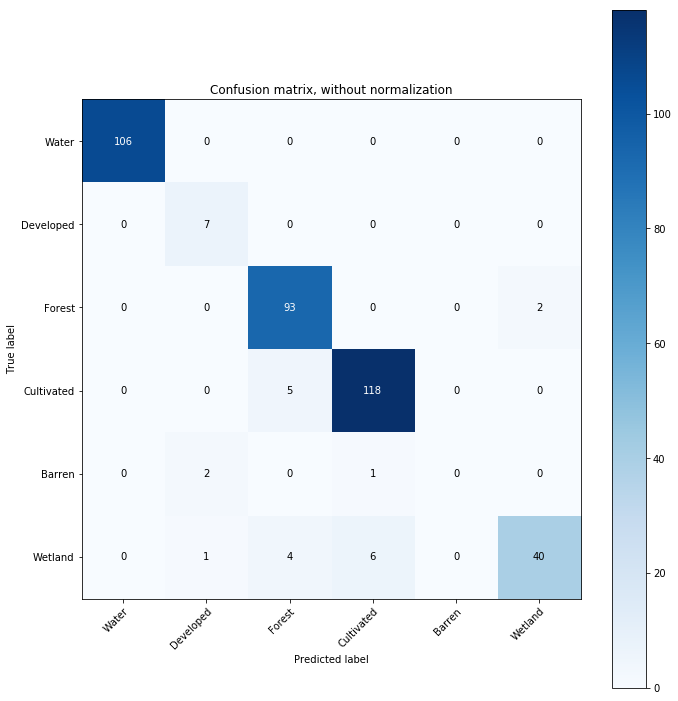

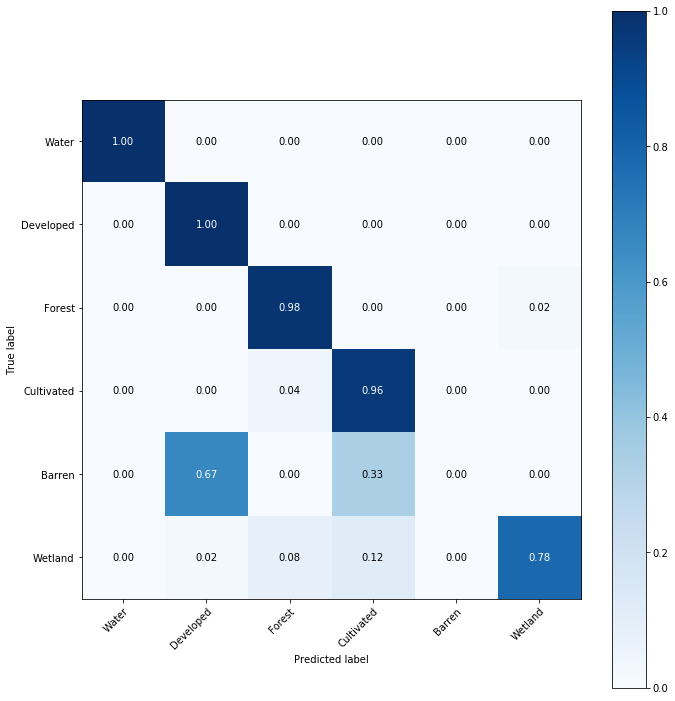

In [78]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1

val_accuracy=count/len(label_index)
print("Accuracy is",val_accuracy)

In [79]:
total = 0
tot = 0
for count in range(len(canopy_pred)):
    if canopy_true[count] != 0 and canopy_pred[count] !=0:
        if canopy_pred[count] < 0:
            canopy_pred[count] = 0
        total+= np.absolute(canopy_pred[count] - canopy_true[count])
        tot+=1
print(total/tot)

[0.11]


In [80]:
from sklearn.metrics import r2_score
validation_r2 = r2_score(canopy_true, canopy_pred)
validation_r2

0.915591691191909

In [81]:
import pandas as pd
import seaborn as sns
pred_df = pd.DataFrame({'lc_pred': pred_index,
                        'lc_true': label_index,
                        'canopy_pred': canopy_pred.flatten(),
                        'canopy_true': canopy_true.flatten()})

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?experimentKey=3727ff80c0cb4aca9ba601b7db703d87&imageId=182c731ebbd644ac97aa5317f5a75e26',
 'web': 'https://www.comet.ml/api/image/download?experimentKey=3727ff80c0cb4aca9ba601b7db703d87&imageId=182c731ebbd644ac97aa5317f5a75e26'}

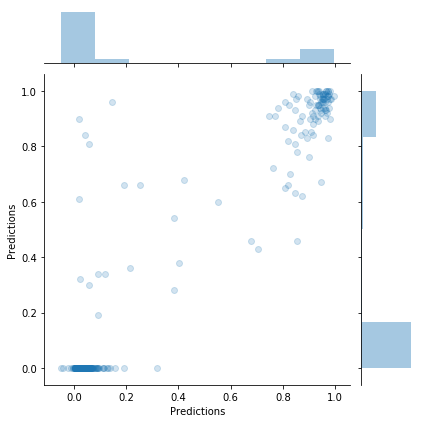

In [82]:
x=pred_df['canopy_pred']
y=pred_df['canopy_true']

from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


g = sns.jointplot(x,y, kind='scatter', alpha=0.2)
g.ax_joint.set_xticks(np.linspace(0,1,6))
g.ax_joint.set_xlabel("Predictions")
g.ax_joint.set_ylabel("Predictions")
experiment.log_figure(figure_name="canopy_scatterplot")

In [83]:
params = {
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "clean_pixels_counts":clean_pixels_count,
    "max_count_per_class": max_count_per_class,
    "class_count_dict":['{} : {}'.format(k,v) for k,v in class_count_dict.items()],
    "steps_division_factor":steps_division_factor,
    "canopy_validation_r2":validation_r2,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [84]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/clifgray/chronos/3727ff80c0cb4aca9ba601b7db703d87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_canopy_loss [60]                        : (0.02368972823023796, 0.2600444555282593)
COMET INFO:     batch_canopy_mean_absolute_error [60]         : (0.02368972823023796, 0.2600444555282593)
COMET INFO:     batch_landcover_acc [60]                      : (0.0, 1.0)
COMET INFO:     batch_landcover_loss [60]                     : (0.04854108765721321, 1.823378562927246)
COMET INFO:     batch_loss [60]                               : (0.08979175984859467, 2.0613291263580322)
COMET INFO:     canopy_loss [30]                              : (0.04944532397477066, 0.21670501985970667)
COMET INFO:     canopy_mean_absolute_error [30]               : (0.04944532397477066, 0.21670501985970667)
COMET INFO:     epoch_duration [30]                 

### Inspect Training Data

In [40]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

7200/7200 [==============================] - 238s 33ms/step


In [41]:
lc_predictions_train = np.asarray(predictions[0])
canopy_pred_train = np.asarray(predictions[1])
lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [42]:
lc_lab_train = np.empty(lc_predictions_train.shape)
canopy_true_train = np.empty(canopy_pred_train.shape)
count = 0
while count < len(lc_predictions_train):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true_train[count] = label_b['canopy']
        lc_lab_train[count] = label_lc
        count += 1
label_index = lc_lab_train.reshape(len(train_px))
pred_index = lc_predictions_train.reshape(len(train_px))

((array([5540.,  104.,  111.,   79.,   46.,   56.,   63.,   97.,  248.,
          856.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <a list of 10 Patch objects>),
 (array([1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.10e+01, 5.76e+03,
         1.14e+02, 6.90e+01, 1.21e+02, 1.12e+03]),
  array([-1.21, -0.99, -0.76, -0.54, -0.31, -0.09,  0.14,  0.36,  0.59,
          0.81,  1.04], dtype=float32),
  <a list of 10 Patch objects>))

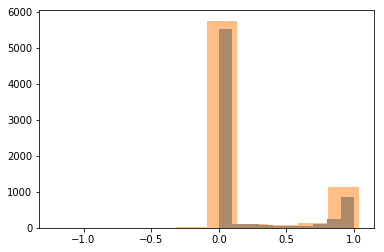

In [43]:
plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [44]:
from sklearn.metrics import r2_score
r2_score(canopy_true_train, canopy_pred_train)

0.9298788612419028

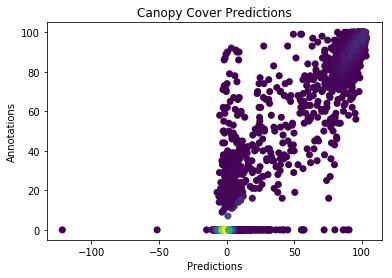

In [45]:
from scipy.stats import gaussian_kde

x = (canopy_pred_train * 100).flatten()
y = (canopy_true_train * 100).flatten()

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='')
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.show()